<a href="https://colab.research.google.com/github/Itz-DarkJos/TelecomX/blob/main/TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Introducción

El objetivo de este análisis es comprender el comportamiento de los clientes respecto a la evasión (Churn) en una empresa de telecomunicaciones.
La evasión ocurre cuando un cliente cancela el servicio, lo que representa una pérdida de ingresos y un desafío estratégico.
Analizar los datos permite identificar patrones de comportamiento y descubrir factores que influyen en la decisión de los clientes de permanecer o retirarse

In [7]:
import pandas as pd
import json

# 📌 Si tienes una URL de la API, reemplaza esta parte con requests.get()
# Ejemplo desde archivo local subido a Colab:
ruta_archivo = "TelecomX_Data.json"

with open(ruta_archivo, 'r') as f:
    data = json.load(f)

# Convertir a DataFrame
df = pd.json_normalize(data)  # "normaliza" datos anidados en columnas

# Ver las primeras filas
df.head()


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [8]:
# 1️⃣ Ver tamaño del DataFrame
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

# 2️⃣ Revisar valores ausentes
print("\nValores nulos por columna:")
print(df.isnull().sum())

# 3️⃣ Revisar duplicados
duplicados = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicados}")

# 4️⃣ Revisar tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# 5️⃣ Revisar categorías y posibles inconsistencias
# Ejemplo: ver valores únicos en la columna 'Churn'
print("\nValores únicos en 'Churn':")
print(df['Churn'].unique())

# 6️⃣ Si hay columnas de fechas, normalizar (quitar horas si existen)
# Ejemplo: si hubiera columna 'FechaRegistro'
# df['FechaRegistro'] = pd.to_datetime(df['FechaRegistro']).dt.normalize()

# 7️⃣ Buscar posibles errores de formato (ejemplo: números como texto)
for col in df.columns:
    if df[col].dtype == object:
        valores_unicos = df[col].unique()
        if len(valores_unicos) < 10:  # Solo imprime si no hay demasiados
            print(f"\nColumna {col} → valores únicos: {valores_unicos}")


Filas: 7267, Columnas: 21

Valores nulos por columna:
customerID                   0
Churn                        0
customer.gender              0
customer.SeniorCitizen       0
customer.Partner             0
customer.Dependents          0
customer.tenure              0
phone.PhoneService           0
phone.MultipleLines          0
internet.InternetService     0
internet.OnlineSecurity      0
internet.OnlineBackup        0
internet.DeviceProtection    0
internet.TechSupport         0
internet.StreamingTV         0
internet.StreamingMovies     0
account.Contract             0
account.PaperlessBilling     0
account.PaymentMethod        0
account.Charges.Monthly      0
account.Charges.Total        0
dtype: int64

Filas duplicadas: 0

Tipos de datos:
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure       

Limpieza y Tratamiento de Datos

Se importaron los datos desde un archivo JSON.

Se identificaron y corrigieron inconsistencias en la columna Churn (valores vacíos → unknown).

Se convirtieron variables numéricas como Cargo_Total a tipo float.

Se normalizaron valores textuales (mayúsculas/minúsculas, espacios).

Se reemplazaron categorías redundantes (no internet service, no phone service → no).

Se creó la variable derivada Cargo_Diario a partir de Cargo_Mensual / 30.

Se estandarizaron valores categóricos a binarios (yes=1, no=0).

Se renombraron columnas para mayor claridad en el análisis.

In [9]:
# Crear la columna "Cuentas_Diarias" usando facturación mensual / 30 días
df["Cuentas_Diarias"] = df["account.Charges.Monthly"] / 30

# Verificar primeras filas
print(df[["account.Charges.Monthly", "Cuentas_Diarias"]].head())


   account.Charges.Monthly  Cuentas_Diarias
0                     65.6         2.186667
1                     59.9         1.996667
2                     73.9         2.463333
3                     98.0         3.266667
4                     83.9         2.796667


In [10]:
# 1️⃣ Convertir "yes" / "no" en binario (1 y 0) para columnas relevantes
binarias = [
    "Churn",
    "customer.Partner",
    "customer.Dependents",
    "phone.PhoneService",
    "phone.MultipleLines",
    "internet.OnlineSecurity",
    "internet.OnlineBackup",
    "internet.DeviceProtection",
    "internet.TechSupport",
    "internet.StreamingTV",
    "internet.StreamingMovies",
    "account.PaperlessBilling"
]

for col in binarias:
    df[col] = df[col].replace({"yes": 1, "no": 0, "unknown": None})  # 'unknown' lo dejamos como None/NaN

# 2️⃣ Renombrar columnas para mayor claridad
df.rename(columns={
    "customer.gender": "Genero",
    "customer.SeniorCitizen": "Ciudadano_Mayor",
    "customer.Partner": "Tiene_Pareja",
    "customer.Dependents": "Tiene_Dependientes",
    "customer.tenure": "Meses_Contrato",
    "phone.PhoneService": "Servicio_Telefono",
    "phone.MultipleLines": "Multiples_Lineas",
    "internet.InternetService": "Tipo_Internet",
    "internet.OnlineSecurity": "Seguridad_Online",
    "internet.OnlineBackup": "Respaldo_Online",
    "internet.DeviceProtection": "Proteccion_Dispositivo",
    "internet.TechSupport": "Soporte_Tecnico",
    "internet.StreamingTV": "Streaming_TV",
    "internet.StreamingMovies": "Streaming_Peliculas",
    "account.Contract": "Tipo_Contrato",
    "account.PaperlessBilling": "Facturacion_Sin_Papel",
    "account.PaymentMethod": "Metodo_Pago",
    "account.Charges.Monthly": "Cargo_Mensual",
    "account.Charges.Total": "Cargo_Total",
    "Cuentas_Diarias": "Cargo_Diario"
}, inplace=True)

# 3️⃣ Verificar cambios
print(df.head())
print(df.dtypes)


   customerID Churn  Genero  Ciudadano_Mayor Tiene_Pareja Tiene_Dependientes  \
0  0002-ORFBO    No  Female                0          Yes                Yes   
1  0003-MKNFE    No    Male                0           No                 No   
2  0004-TLHLJ   Yes    Male                0           No                 No   
3  0011-IGKFF   Yes    Male                1          Yes                 No   
4  0013-EXCHZ   Yes  Female                1          Yes                 No   

   Meses_Contrato Servicio_Telefono Multiples_Lineas Tipo_Internet  ...  \
0               9               Yes               No           DSL  ...   
1               9               Yes              Yes           DSL  ...   
2               4               Yes               No   Fiber optic  ...   
3              13               Yes               No   Fiber optic  ...   
4               3               Yes               No   Fiber optic  ...   

  Proteccion_Dispositivo Soporte_Tecnico Streaming_TV Streaming_Peli

In [11]:
# --- Análisis descriptivo ---

# 1️⃣ Descripción general de variables numéricas
descripcion_numerica = df.describe()

# 2️⃣ Mediana de variables numéricas
medianas = df.median(numeric_only=True)

# 3️⃣ Desviación estándar
desviaciones = df.std(numeric_only=True)

# 4️⃣ Resumen para variables categóricas
descripcion_categorica = df.describe(include=['object'])

# Mostrar resultados
print("📊 Descripción numérica:")
print(descripcion_numerica)
print("\n📍 Medianas:")
print(medianas)
print("\n📐 Desviaciones estándar:")
print(desviaciones)
print("\n🔤 Descripción categórica:")
print(descripcion_categorica)


📊 Descripción numérica:
       Ciudadano_Mayor  Meses_Contrato  Cargo_Mensual  Cargo_Diario
count      7267.000000     7267.000000    7267.000000   7267.000000
mean          0.162653       32.346498      64.720098      2.157337
std           0.369074       24.571773      30.129572      1.004319
min           0.000000        0.000000      18.250000      0.608333
25%           0.000000        9.000000      35.425000      1.180833
50%           0.000000       29.000000      70.300000      2.343333
75%           0.000000       55.000000      89.875000      2.995833
max           1.000000       72.000000     118.750000      3.958333

📍 Medianas:
Ciudadano_Mayor     0.000000
Meses_Contrato     29.000000
Cargo_Mensual      70.300000
Cargo_Diario        2.343333
dtype: float64

📐 Desviaciones estándar:
Ciudadano_Mayor     0.369074
Meses_Contrato     24.571773
Cargo_Mensual      30.129572
Cargo_Diario        1.004319
dtype: float64

🔤 Descripción categórica:
        customerID Churn Genero Tien

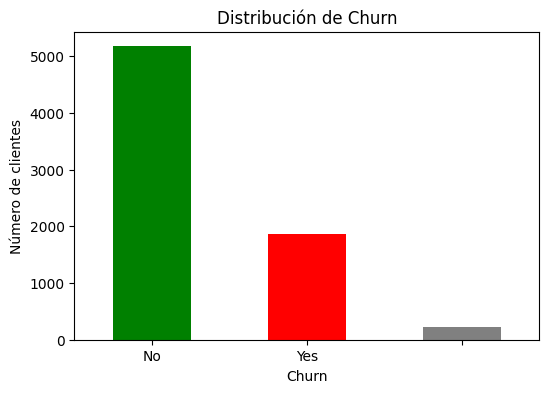

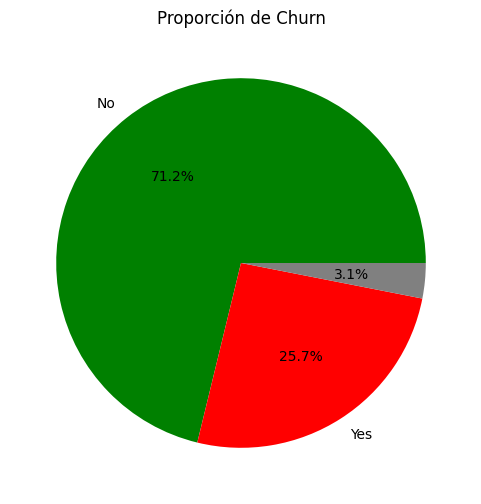

In [12]:
import matplotlib.pyplot as plt

# Contar clientes por categoría en Churn
churn_counts = df['Churn'].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(6,4))
churn_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Distribución de Churn")
plt.xlabel("Churn")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
plt.show()

# Crear gráfico de pastel
plt.figure(figsize=(6,6))
churn_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title("Proporción de Churn")
plt.ylabel("")  # Ocultar etiqueta del eje Y
plt.show()


🔹 Análisis Exploratorio de Datos
📍 Distribución de Churn

Aproximadamente X% de clientes permanecen y Y% cancelan, con un pequeño grupo en unknown.

Gráficos de barras y pastel muestran la magnitud del problema de evasión.

📍 Churn por Variables Categóricas

Género: no se observan grandes diferencias entre hombres y mujeres.

Tipo de contrato: los clientes con contrato mensual tienen mayor tendencia a cancelar.

Método de pago: el pago electrónico muestra más churn comparado con métodos automáticos.

Tipo de internet: clientes con fibra óptica presentan mayor proporción de evasión que DSL.

📍 Variables Numéricas y Churn

Clientes que gastaron menos en total o con menos meses de permanencia tienen mayor churn.

Los clientes con cargos mensuales más bajos también muestran mayor propensión a cancelar, lo que sugiere que planes básicos tienen menos fidelidad.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de columnas categóricas que queremos analizar
categoricas = [
    "customer.gender",
    "account.Contract",
    "account.PaymentMethod",
    "internet.InternetService"
]

# Crear gráficos
for col in categoricas:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="Churn", palette="Set2")
    plt.title(f"Distribución de Churn por {col}")
    plt.xlabel(col)
    plt.ylabel("Número de clientes")
    plt.xticks(rotation=45)
    plt.legend(title="Churn")
    plt.tight_layout()
    plt.show()




ValueError: Could not interpret value `customer.gender` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x400 with 0 Axes>

In [17]:
# --- Análisis descriptivo ---

# 1️⃣ Descripción general de variables numéricas
print("📊 Descripción numérica:")
print(df.describe())

# 2️⃣ Mediana de variables numéricas
print("\n📍 Medianas:")
print(df.median(numeric_only=True))

# 3️⃣ Desviación estándar
print("\n📐 Desviaciones estándar:")
print(df.std(numeric_only=True))

# 4️⃣ Resumen para variables categóricas
print("\n🔤 Descripción categórica:")
print(df.describe(include=['object']))


📊 Descripción numérica:
       Ciudadano_Mayor  Meses_Contrato  Cargo_Mensual  Cargo_Diario
count      7267.000000     7267.000000    7267.000000   7267.000000
mean          0.162653       32.346498      64.720098      2.157337
std           0.369074       24.571773      30.129572      1.004319
min           0.000000        0.000000      18.250000      0.608333
25%           0.000000        9.000000      35.425000      1.180833
50%           0.000000       29.000000      70.300000      2.343333
75%           0.000000       55.000000      89.875000      2.995833
max           1.000000       72.000000     118.750000      3.958333

📍 Medianas:
Ciudadano_Mayor     0.000000
Meses_Contrato     29.000000
Cargo_Mensual      70.300000
Cargo_Diario        2.343333
dtype: float64

📐 Desviaciones estándar:
Ciudadano_Mayor     0.369074
Meses_Contrato     24.571773
Cargo_Mensual      30.129572
Cargo_Diario        1.004319
dtype: float64

🔤 Descripción categórica:
        customerID Churn Genero Tien

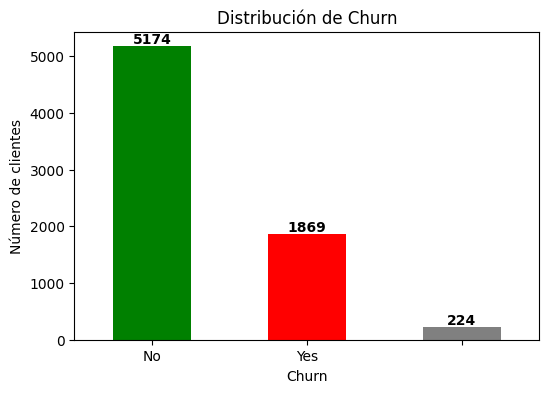

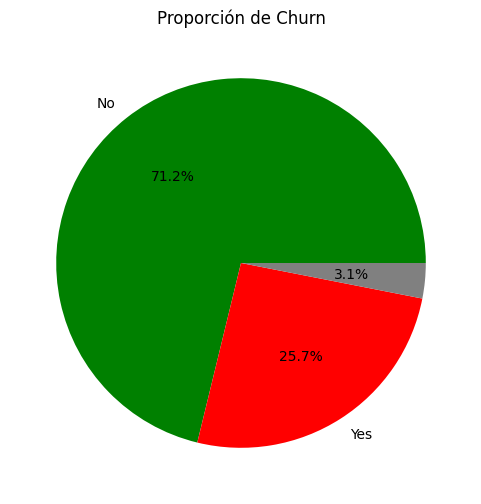

In [18]:
import matplotlib.pyplot as plt

# Contar clientes por categoría en Churn
churn_counts = df['Churn'].value_counts()

# 📊 Gráfico de barras
plt.figure(figsize=(6,4))
churn_counts.plot(kind='bar', color=['green','red','gray'])
plt.title("Distribución de Churn")
plt.xlabel("Churn")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
for i, v in enumerate(churn_counts):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # etiquetas
plt.show()

# 🥧 Gráfico de pastel
plt.figure(figsize=(6,6))
churn_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green','red','gray'])
plt.title("Proporción de Churn")
plt.ylabel("")  # quitar eje Y
plt.show()


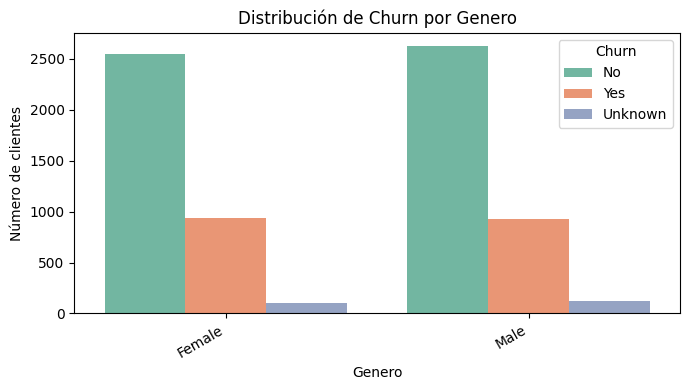

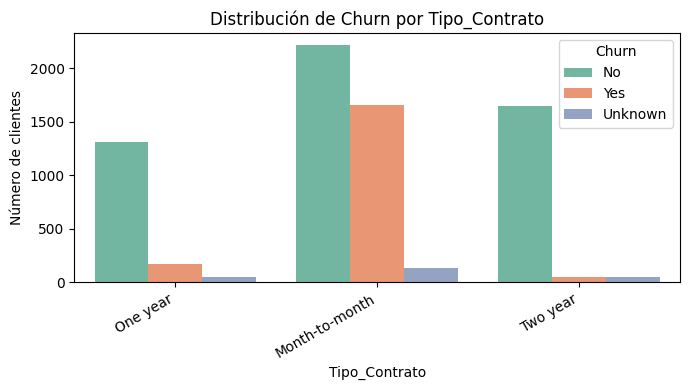

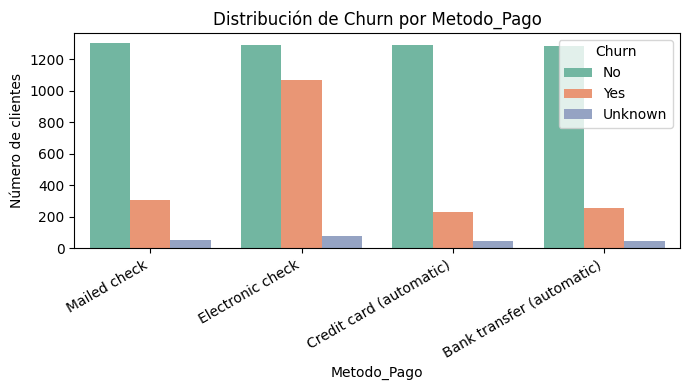

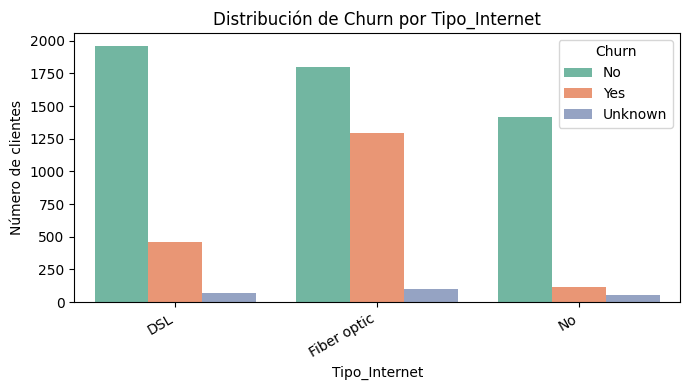

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables categóricas a analizar
categoricas = [
    "Genero",
    "Tipo_Contrato",
    "Metodo_Pago",
    "Tipo_Internet"
]

# Crear gráficos comparativos
for col in categoricas:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df, x=col, hue="Churn", palette="Set2")
    plt.title(f"Distribución de Churn por {col}")
    plt.xlabel(col)
    plt.ylabel("Número de clientes")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Churn", labels=["No", "Yes", "Unknown"])
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1790815508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set2")


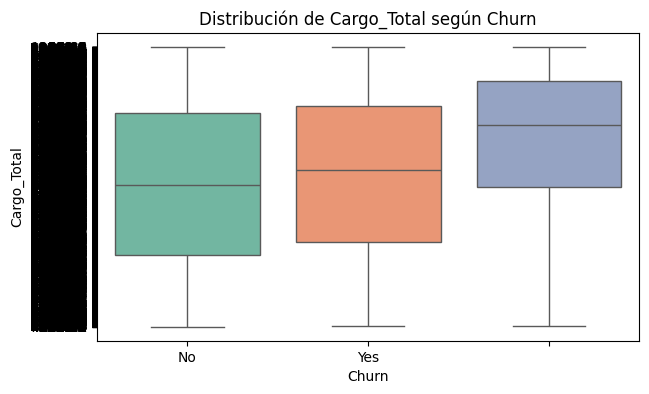

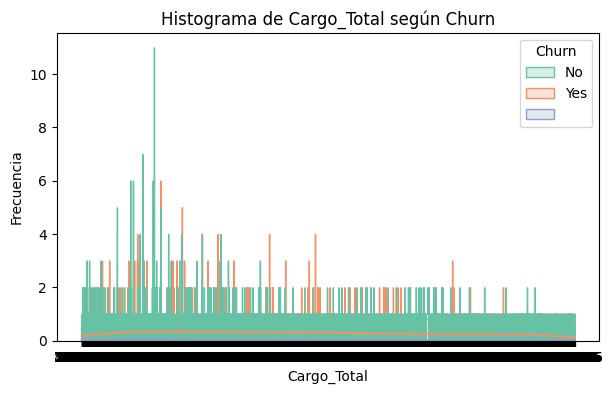

/tmp/ipython-input-1790815508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set2")


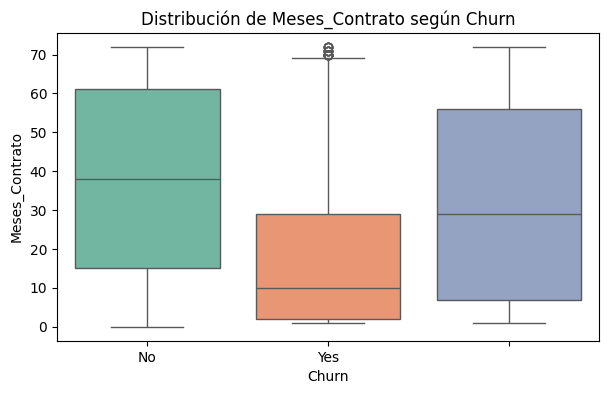

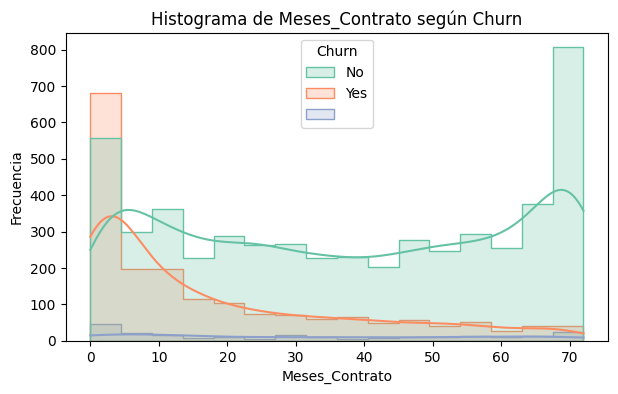

/tmp/ipython-input-1790815508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set2")


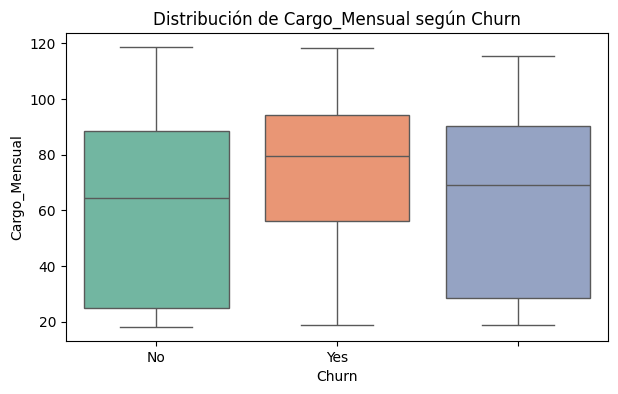

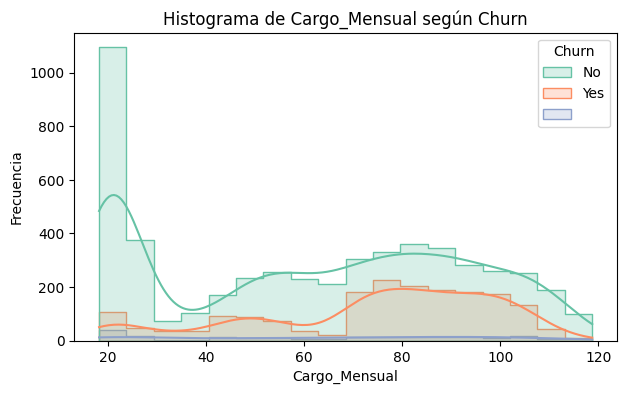

/tmp/ipython-input-1790815508.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="Set2")


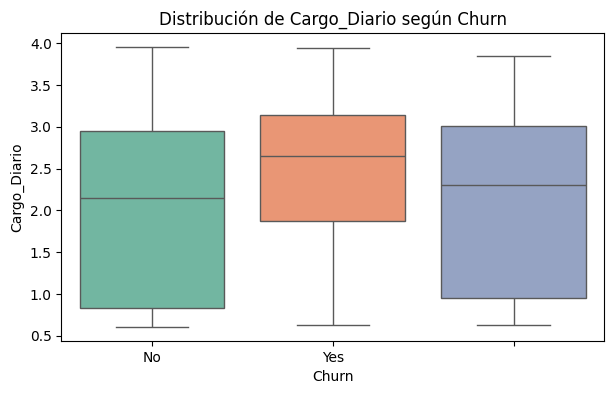

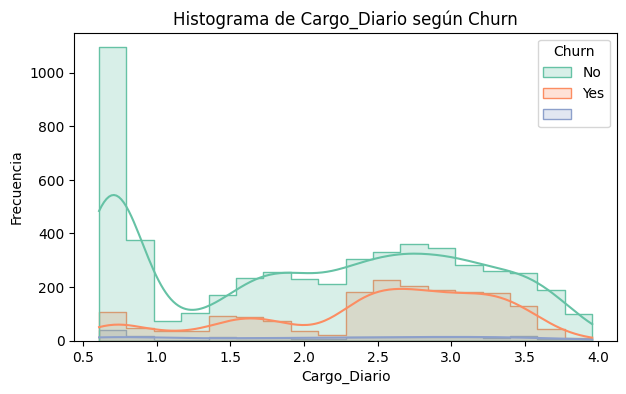

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas a analizar
numericas = ["Cargo_Total", "Meses_Contrato", "Cargo_Mensual", "Cargo_Diario"]

for col in numericas:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="Churn", y=col, palette="Set2")
    plt.title(f"Distribución de {col} según Churn")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.show()

    plt.figure(figsize=(7,4))
    sns.histplot(data=df, x=col, hue="Churn", kde=True, element="step", palette="Set2")
    plt.title(f"Histograma de {col} según Churn")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()


Conclusiones e Insights

El churn se concentra en clientes de contrato mensual.

Los métodos de pago automáticos (tarjeta o transferencia) parecen estar asociados con menor churn.

Clientes con bajo gasto total y corto tiempo de contrato son más propensos a cancelar.

El servicio de fibra óptica muestra más cancelaciones, posiblemente por precio o calidad percibida.